# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
import math
from numpy.random import RandomState
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
RANDOM_STATE = 2023
TEST_SIZE = 0.25
BUDGET = 10e9
BARREL = 450000
WELL_COUNT = 200

In [3]:
try:
    data_1 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    data_1 = pd.read_csv('https://code.s3.yandex.net/geo_data_0.csv')

try:
    data_2 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    data_2 = pd.read_csv('https://code.s3.yandex.net/geo_data_1.csv')
    
try:
    data_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_3 = pd.read_csv('https://code.s3.yandex.net/geo_data_2.csv')

Посмотрим, какие данные представлены в таблицах.

In [4]:
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
print(data_1.info(),'\n')
print(data_2.info(), '\n')
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

Можно с уверенностью сказать, что в данных нет пропусков и таблице по структуре схожи. Проверим данные на дубликаты.

In [8]:
data_1.duplicated().sum()

0

In [9]:
data_2.duplicated().sum()

0

In [10]:
data_3.duplicated().sum()

0

Полных дубликатов в данных нет. В таблицах есть уникальные идентификаторы, которые лучше всегда исключать, так как есть вероятность переобучения модели на них. Перед удалением проверим данный столбец на дубликаты.

In [11]:
data_1['id'].duplicated().sum()

10

In [12]:
data_1[data_1['id'].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


Видим, что в первом регионе есть дубликаты по столбцу `id`. Их можно оставть, либо удалить, т.к. они занимают 0.0001 процент от данных. Это никак не помешают нашему анализу.

In [13]:
data_1 = data_1.drop_duplicates(subset='id').reset_index(drop=True)

In [14]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Видим, что дубликаты были удалены. Проверим второй регион.

In [15]:
data_2['id'].duplicated().sum()

4

In [16]:
data_2 = data_2.drop_duplicates(subset='id').reset_index(drop=True)

In [17]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Во втором датасете мы также удалили 4 дубликата. Приступим к проверке третьего региона.

In [18]:
data_3['id'].duplicated().sum()

4

In [19]:
data_3 = data_3.drop_duplicates(subset='id').reset_index(drop=True)

In [20]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В трёх датасетах были обнаружены дубликаты, их колиство слишком мало, поэтому было принято решение их удалить, т.к. данные не будут искажены. Теперь исключим столбец `id` из наших данных, т.к. он нам больше не пригодится.

In [21]:
data_1 = data_1.drop(['id'] , axis=1)
data_2 = data_2.drop(['id'] , axis=1)
data_3 = data_3.drop(['id'] , axis=1)

Посмотрим на распределение данных в каждом регионе.

In [22]:
data_1.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


In [23]:
data_2.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [24]:
data_3.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


Также можно проверить корреляцию в данных датасетов. Построим матрицы корреляции и для удобства визуализируем хитмэпом.

In [25]:
data_1.corr(method='spearman')

,f0,f1,f2,product
f0,1.000000,-0.471379,-0.002739,0.128379
f1,-0.471379,1.000000,0.001440,-0.181136
f2,-0.002739,0.001440,1.000000,0.486370
product,0.128379,-0.181136,0.486370,1.000000


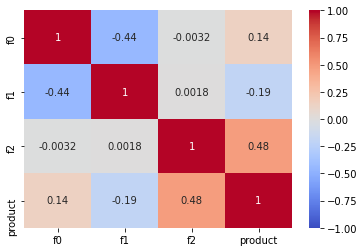

In [26]:
sns.heatmap(data_1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

In [27]:
data_2.corr(method='spearman')

,f0,f1,f2,product
f0,1.000000,0.182247,-0.002024,-0.122901
f1,0.182247,1.000000,-0.003674,-0.033906
f2,-0.002024,-0.003674,1.000000,0.975604
product,-0.122901,-0.033906,0.975604,1.000000


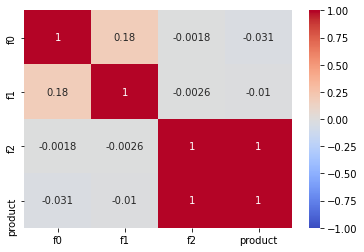

In [28]:
sns.heatmap(data_2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

Можно заметить, что данные в столбце `f2` очень сильно коррелируют с целевым показателем `product`. Высокий коэффициент корреляции признака и целевой переменной в пользу точности предсказаний.

In [29]:
data_3.corr(method='spearman')

,f0,f1,f2,product
f0,1.000000,0.002471,0.000046,-0.002453
f1,0.002471,1.000000,0.000349,-0.001508
f2,0.000046,0.000349,1.000000,0.448459
product,-0.002453,-0.001508,0.448459,1.000000


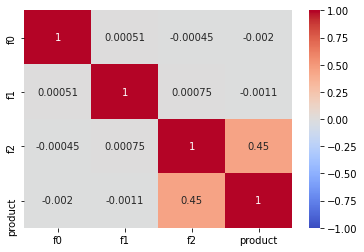

In [30]:
sns.heatmap(data_3.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm');

Посмотрев на корреляцию в данных, можно сделать вывод, что целевой признак во всех датасетах больше всего зависит от признака `f2`.

Посмотрим распределение признаков и целевой переменной для каждого региона. Посмотрим на гистограммы каждого датасета.

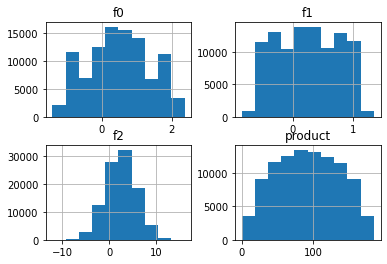

In [31]:
data_1.hist();

В первом датасете целевой показатель и показатель `f2` имеют нормальное распределение. Остальные показатели имеют провалы в распределении.

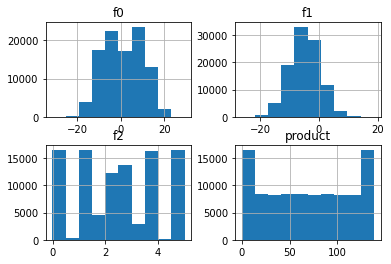

In [32]:
data_2.hist();

Во втором регионе целевой прзнак имеет сильный перекос в начале и в конце распределения данных. Показатель `f2` также распределен хаотично, скорее всего из-за того, что сильно коррелирует с целевым признаком. Показатель `f1` имеет более нормальное распределение, чем показатель `f0`, у которого есть провал в середине даанных.

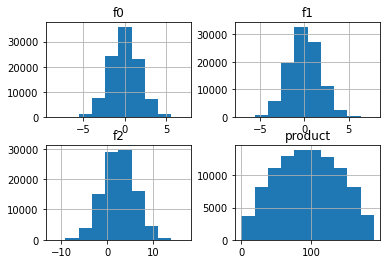

In [33]:
data_3.hist();

В третьем датасете все показатели имеют нормальное распределение, без явных скачков и перепадов.

Подготовим данные для обучения. Разделим датасеты на `target` и `features`.

In [34]:
features_1 = data_1.drop('product', axis=1)
target_1 = data_1['product']

In [35]:
features_2 = data_2.drop('product', axis=1)
target_2 = data_2['product']

In [36]:
features_3 = data_3.drop('product', axis=1)
target_3 = data_3['product']

Данные подготовлены, теперь можно перейти к обучению и проверке модели.

## Обучение и проверка модели

### Обучение и проверка модели для первого региона

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [37]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1,
                                                                              target_1,
                                                                              test_size=TEST_SIZE,
                                                                              random_state=RANDOM_STATE, 
                                                                              shuffle=True)

Проверим размеры выборок.

In [38]:
print(f'Тренировочная выборка: {features_train_1.shape}.')
print(f'Валидационная выборка: {features_valid_1.shape}.')

Тренировочная выборка: (74992, 3).
Валидационная выборка: (24998, 3).


Проведем масштабирование данных, т.к. мы будем применять линейную регрессию. Будем использовать `MinMaxScaler`, т.к. данные в первом датасете распределены не во всех столбцах нормально.

In [39]:
mmscaler = MinMaxScaler()
features_train_1 = pd.DataFrame(mmscaler.fit_transform(features_train_1))
features_valid_1 = pd.DataFrame(mmscaler.transform(features_valid_1))

Проверим, как выглядят данные.

In [40]:
features_train_1.head()

,0,1,2
0,0.858088,0.328746,0.431529
1,0.121646,0.403109,0.681714
2,0.313649,0.873212,0.307012
3,0.125264,0.617869,0.419312
4,0.122520,0.453831,0.404160


Теперь пришло время обучить модель и сделать предсказания на валидационной выборке.

Создадим функцию, которая будет:
- обучать модель и предсказывать данные;
- выводить на экран средний запас предсказанного сырья и `RMSE` модели.

In [41]:
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predicted_valid_1 = model.predict(features_valid_1)

Сохраним предсказания и правильные ответы на валидационной выборке, создав отдельный датафрейм.

In [42]:
df_1 = pd.DataFrame()
df_1['prediction'] = predicted_valid_1 
df_1['product'] = target_valid_1.reset_index(drop=True)

Посмотрим на средний запас предсказанного сырья и `RMSE` модели.

In [43]:
mse = mean_squared_error(target_valid_1, predicted_valid_1)
print('Средний запас предсказанного сырья:', predicted_valid_1.mean())
print("RMSE =", mse ** 0.5)

Средний запас предсказанного сырья: 92.58912508150183
RMSE = 37.62166944945255


- Средний запас предсказанного сырья в первом регионе 92.59 тыс. баррелей.
- RMSE - это квадратный корень из средней квадратичной ошибки и равняется 37.46 тыс. баррелей. Слишком большое значение для данной метрики в нашем случае.

### Обучение и проверка модели для второго региона

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [44]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2,
                                                                              target_2,
                                                                              test_size=TEST_SIZE,
                                                                              random_state=RANDOM_STATE)

Проверим размеры выборок.

In [45]:
print(f'Тренировочная выборка: {features_train_2.shape}.')
print(f'Валидационная выборка: {features_valid_2.shape}.')

Тренировочная выборка: (74997, 3).
Валидационная выборка: (24999, 3).


Проведем масштабирование данных, т.к. мы будем применять линейную регрессию. Во втором датасете также даные распределены не нормально.

In [46]:
mmscaler = MinMaxScaler()
features_train_2 = pd.DataFrame(mmscaler.fit_transform(features_train_2))
features_valid_2 = pd.DataFrame(mmscaler.transform(features_valid_2))

Обучим модель для второго региона и предскажем целевой показатель.

In [47]:
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predicted_valid_2 = model.predict(features_valid_2)

Сохраним предсказания и правильные ответы на валидационной выборке, создав отдельный датафрейм.

In [48]:
df_2 = pd.DataFrame()
df_2['prediction'] = predicted_valid_2 
df_2['product'] = target_valid_2.reset_index(drop=True)

Посмотрим на средний запас предсказанного сырья и RMSE модели.

In [49]:
mse = mean_squared_error(target_valid_2, predicted_valid_2)
print('Средний запас предсказанного сырья:', predicted_valid_2.mean())
print("RMSE =", mse ** 0.5)

Средний запас предсказанного сырья: 68.65421500612776
RMSE = 0.8858720945141563


- Средний запас предсказанного сырья равен 68.65 тыс. баррелей, что значительно меньше, чем в первом регионе;
- RMSE во втором регионе показывает очень маленькое значение, в отличии от первого региона; 
- это очень хорошо, если ошибка меньше, значит прогноз точнее и модель лучше обучилась.

### Обучение и проверка модели для третьего региона

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [50]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(features_3,
                                                                              target_3,
                                                                              test_size=TEST_SIZE,
                                                                              random_state=RANDOM_STATE)

In [51]:
print(f'Тренировочная выборка: {features_train_3.shape}.')
print(f'Валидационная выборка: {features_valid_3.shape}.')

Тренировочная выборка: (74997, 3).
Валидационная выборка: (24999, 3).


Проведем масштабирование данных, т.к. мы будем применять линейную регрессию. В третьем датасете данные имеют распределение ближе к нормальному, поэтому применним `StandardScaler`.

In [52]:
scaler = StandardScaler()
scaler.fit(features_train_3)
features_train_3 = pd.DataFrame(scaler.transform(features_train_3))
features_valid_3 = pd.DataFrame(scaler.transform(features_valid_3))

Обучим модель для третьего региона и предскажем значения.

In [53]:
model = LinearRegression()
model.fit(features_train_3, target_train_3)
predicted_valid_3 = model.predict(features_valid_3)

Сохраним предсказания и правильные ответы на валидационной выборке, создав отдельный датафрейм.

In [54]:
df_3 = pd.DataFrame()
df_3['prediction'] = predicted_valid_3
df_3['product'] = target_valid_3.reset_index(drop=True)

Посмотрим на средний запас предсказанного сырья и RMSE модели.

In [55]:
mse = mean_squared_error(target_valid_3, predicted_valid_3)
print('Средний запас предсказанного сырья:', predicted_valid_3.mean())
print("RMSE =", mse ** 0.5)

Средний запас предсказанного сырья: 94.82809359736106
RMSE = 40.15909396294103


- RMSE равняется 40,15 тыс. баррелей, что является самым высоким резульатом, чем выше ошибка, тем хуже работает модель;
- Средний запас предсказанного сырья 95 тыс. баррелей, что также является самым высоким показателем.

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе — 10 млрд рублей. Присвоем данное значение константе `BUDGET`.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. Укажем доход в константе `BARREL`. Количество скважин на которые распределяется бюджет равняется 200 и записывается в переменную `WELL_COUNT`.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Для этого бюджет поделим на доход за один баррель и количество предполагаемых скважин и найдем количество баррелей, которое будет в бюджете.

In [56]:
size = BUDGET / (BARREL * WELL_COUNT)
math.ceil(size)

112

С помощью расчётов мы определили, что в каждой скважине необходимо, чтобы было около 112 тыс. баррелей для безубыточной разработки скважины.

Средние запасы скважин в каждом регионе намного меньше, чем требуется для безубыточности.

In [57]:
def target_level(data, count):
    av = data.mean()
    result = size / av
    print(f'В {count} регионе количество средних запасов в {result} раз ниже, чем необходимо для безубыточной разработки скважины')

In [58]:
target_level(target_1, 1)

В 1 регионе количество средних запасов в 1.2012053019506146 раз ниже, чем необходимо для безубыточной разработки скважины


In [59]:
target_level(target_2, 2)

В 2 регионе количество средних запасов в 1.6144258813088814 раз ниже, чем необходимо для безубыточной разработки скважины


In [60]:
target_level(target_3, 3)

В 3 регионе количество средних запасов в 1.169611054596479 раз ниже, чем необходимо для безубыточной разработки скважины


Исходя из анализа данных и подготовки расчёта прибыли, можно сделать выводы, что:
- в каждом регионе средний объем сырья меньше достаточного объёма для безубыточности, поэтому точность прогноза имеет большое значение и без модели нам не обойтись;
- есть 25 000 точек, из которых в результате надо выбрать 200. В результате,  среди этих скважин могут быть скважины с достаточным и недостаточным запасом сырья.

Имеено техника "Bootstrap" опираясь на предсказания позволяет оценить риск убытков при случайным отборе 500 точек. 1000 раз отбирая случайным образом точки, считаем какой % случаев принесет убытки.

## Расчёт прибыли и рисков 

### Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [61]:
def profit(reals, preds, count):
    probs_sorted = preds.sort_values(ascending=False)
    selected = reals[probs_sorted.index][:count]
    prof = (BARREL * selected.sum()) - BUDGET
    return prof

Напишем еще одну функцию для более удобного вывода информации.

In [62]:
def profit_write(reals, preds, count):
    if profit(reals, preds, count) > 0:
        print(f'Прибыль для полученного объёма сырья составляет {profit(reals, preds, count)} р.')
    else:
        print(f'Убыток для полученного объёма сырья составляет {profit(reals, preds, count)} р.')

При подсчете получим прибыль от топ-200 скважин в каждом регионе.

In [63]:
profit_write(df_1['product'], df_1['prediction'], 200)

Прибыль для полученного объёма сырья составляет 3356349222.617914 р.


In [64]:
profit_write(df_2['product'], df_2['prediction'], 200)

Прибыль для полученного объёма сырья составляет 2415086696.681511 р.


In [65]:
profit_write(df_3['product'], df_3['prediction'], 200)

Прибыль для полученного объёма сырья составляет 2557971424.3160496 р.


### Подсчёт рисков и прибыли для каждого региона

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [66]:
state = RandomState(12345)

При семплировании данных устанавливаем `replace = True`, это необходимо чтобы наблюдение в выборку попало несколько раз, что позволяет добиться независимости при каждом выборе, иначе вероятность достать элемент из выборки будет с каждым разом увеличиваться. Чем больше размер подвыборки, тем выраженнее будет зависимость, поэтому без возврата не удастся получить разнообразные варианты, а подвыборку бОльшего размера вообще не получить.

In [67]:
def bootstrap(reals_s, preds_s, number):
    values = []
    for i in range(1000):
        reals_subsample = reals_s.sample(n=500, replace=True, random_state=state)
        prediction_subsample = preds_s[reals_subsample.index]
        values.append(profit(reals_subsample, prediction_subsample, 200))
    values = pd.Series(values)
    
    print(f'Средняя прибыль на {number} участке среди 200 скважин будет равняться: {round(values.mean(),2)}')
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print(f'95-ый доверительный интервал для {number} региона: ({round(lower, 2)}, {round(upper, 2)}).')
    
    risk = values[values < 0].count() / values.count() * 100
    print(f'Риск убытков для {number} региона: {round(risk, 2)}%.')


В функции также будет расчитаны следующие показатели:
- средняя прибыль в регионе среди 200 скважин;
- 95-ый доверительный интервал;
- риск убытков.

Убыток — это отрицательная прибыль. Риск убытков посчитаем, как число убытков из выборки деленное на число всех значений выборки.

In [68]:
bootstrap(df_1['product'], df_1['prediction'], 1)

Средняя прибыль на 1 участке среди 200 скважин будет равняться: 461509393.73
95-ый доверительный интервал для 1 региона: (-54940911.19, 998489744.13).
Риск убытков для 1 региона: 3.9%.


In [69]:
bootstrap(df_2['product'], df_2['prediction'], 2)

Средняя прибыль на 2 участке среди 200 скважин будет равняться: 490160781.27
95-ый доверительный интервал для 2 региона: (70970914.74, 961467266.0).
Риск убытков для 2 региона: 1.2%.


In [70]:
bootstrap(df_3['product'], df_3['prediction'], 3)

Средняя прибыль на 3 участке среди 200 скважин будет равняться: 374308754.64
95-ый доверительный интервал для 3 региона: (-169163869.01, 936394644.32).
Риск убытков для 3 региона: 8.5%.


Что такое  `quantile()` очень хорошо объясняет пример - 0.5-й квантиль, это, по сути, медиана, т.е. функция `quantile(0.5)` должна вернуть такое значение, которое меньше ровно половины элементов массива.
`quantile(0.025)` находит такое значение прибыли,  меньше которого только 2,5% элементов. И если это значение прибыли положительное, значит и риск меньше 2,5%. <br>
Выбирая наугад 1000 раз 500 случайных скважин и отбирая из них 200 лучших, убыток получаем менее, чем в 2,5% случаев только во втором регионе.

## Итоговый вывод

Исходя из результатов, можно сделать несколько выводов:
- первый регион показал неплохую среднюю прибыль, но доверительный интервал имеет отрицательное значение на нижней границе, также риск убытков составляет 3.9 процентов, что больше, чем в задании;
- второй регион показал самую лучшую среднюю прибыль, доверительный интервал также получился самый лучший, без отрицательных значений, соответсвенно и риск убытков составляет всего 1.2 процент;
- третий регион имеет самую маленькую среднюю прибыль, доверительный интервал также как и в первом уходит в отрицательную зону, только на более высокие значения, риск убытков составляет самый большой результат среди всех регионов и равняется 8.5 процентов.

**После анализа трёх регионов, можно с уверенностью сказать, что для безубыточного бурения скважин лучше выбрать второй регион. Во этом регионе минимальный % риска, т.к. модель предсказывает хорошо (ошибка минимальная). А при выборе 200 лучших скважин мы опираемся на предсказания, поэтому ничего удивительного  -  регион победил!**